In [218]:
#Loading
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
#Modeling
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
#Visual
import matplotlib.pyplot as plt
import pylab as plt
import seaborn as sns
#For TfIdf
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from cycler import cycler

In [219]:
df = pd.read_csv('test_data.csv')

In [220]:
df

,customer_id,order_number,delivery_date,delivery_week,final_payment_status,time_to_pay,payment_method,custom_meal_selection,state,channel,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid,avg_recipe_rating
0,6,17266,20200229,2020-W10,Cancelled,NaN,X,Unknown,B,O,3,1,0,NaN
1,7,10494,20200301,2020-W10,Paid,15.0,W,Yes,D,O,29,14,0,4.00
2,8,10384,20200303,2020-W10,Paid,101.0,Z,Yes,B,S,17,9,0,NaN
3,9,3396,20200303,2020-W10,Paid,1.0,W,Yes,F,O,242,3,0,NaN
4,13,1146,20200302,2020-W10,Paid,22.0,Z,Yes,B,O,226,102,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,17922,21627,20200303,2020-W10,Paid,15.0,Z,No,F,F3,13,4,0,NaN
4994,17924,11742,20200303,2020-W10,Paid,1.0,W,Yes,B,A2,3,0,0,4.00
4995,17926,17142,20200301,2020-W10,Paid,167.0,Z,Yes,D,A2,3,2,0,NaN
4996,17932,1157,20200302,2020-W10,Paid,0.0,W,Yes,D,F1,11,0,0,NaN


# Уникальные значения в столбцах

In [221]:
df['delivery_date'].unique()

array([20200229, 20200301, 20200303, 20200302, 20200304], dtype=int64)

In [222]:
df['delivery_week'].unique()

array(['2020-W10'], dtype=object)

In [223]:
df['final_payment_status'].unique()

array(['Cancelled', 'Paid', 'Unpaid', 'Other', 'Refunded'], dtype=object)

In [224]:
df['payment_method'].unique()

array(['X', 'W', 'Z', 'V', 'Y'], dtype=object)

In [225]:
df['custom_meal_selection'].unique()

array(['Unknown', 'Yes', 'No'], dtype=object)

In [226]:
df['state'].unique()

array(['B', 'D', 'F', 'G', 'A', 'E', 'New York', 'C', '<error>'],
      dtype=object)

In [227]:
df['channel'].unique()

array(['O', 'S', 'F2', 'A1', 'D', 'E', 'H', 'F1', 'P', 'A2', 'F3', 'I'],
      dtype=object)

# Количество клиенстов со статусами оплаты

In [228]:
paid = df[(df['final_payment_status'] == 'Paid')]['customer_id'].unique().size
cancelled = df[(df['final_payment_status'] == 'Cancelled')]['customer_id'].unique().size
Unpaid = df[(df['final_payment_status'] == 'Unpaid')]['customer_id'].unique().size
Other = df[(df['final_payment_status'] == 'Other')]['customer_id'].unique().size
Refunded = df[(df['final_payment_status'] == 'Refunded')]['customer_id'].unique().size

# Количество клиентов с методами оплаты

In [229]:
Xmethod = df[(df['payment_method'] == 'X')]['customer_id'].size
Wmethod = df[(df['payment_method'] == 'W')]['customer_id'].size
Zmethod = df[(df['payment_method'] == 'Z')]['customer_id'].size
Vmethod = df[(df['payment_method'] == 'V')]['customer_id'].size
Ymethod = df[(df['payment_method'] == 'Y')]['customer_id'].size

# Графики

## Stackplot

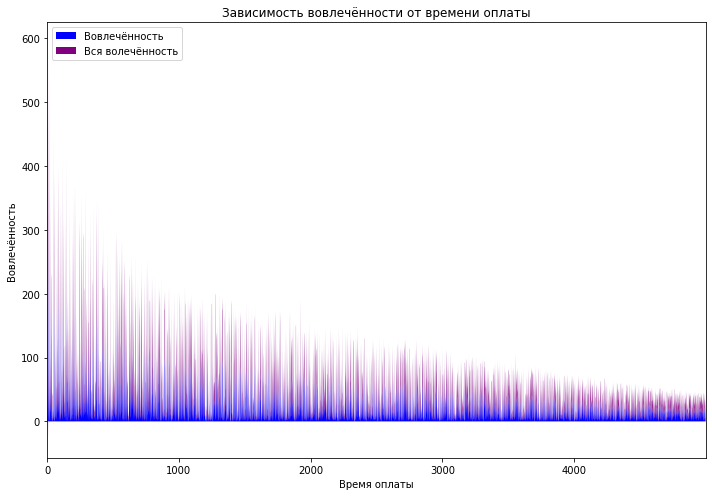

In [230]:
time = df[(df['time_to_pay'] != None)]['engagement_score']

time_stack = np.array(time.sort_index())
time_array = np.array([time.sort_index(), time_stack])

fig, ax = plt.subplots(figsize=(10, 7))
ax.stackplot(time.sort_index().index, time_array, colors =['blue', 'purple'], labels=['Вовлечённость', 'Вся волечённость'])
ax.set_title('Зависимость вовлечённости от времени оплаты')
ax.legend(loc='upper left')
ax.set_xlabel('Время оплаты')
ax.set_ylabel('Вовлечённость')
ax.set_xlim(left = time.index.min(), right = time.index.max())
fig.tight_layout()
 
plt.show()

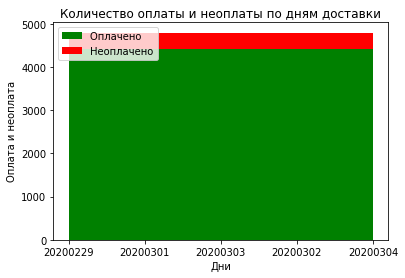

In [231]:
days = ['20200229', '20200301', '20200303', '20200302', '20200304']
# days = [1, 2, 3, 4, 5]

labels = ["Оплачено ", "Неоплачено"]
plt.stackplot(days, paid, Unpaid,
              colors =['g', 'r'], labels=labels)
plt.legend(loc='upper left')
plt.title('Количество оплаты и неоплаты по дням доставки')
plt.xlabel('Дни')
plt.ylabel('Оплата и неоплата')
plt.show()

## pandas plot pie

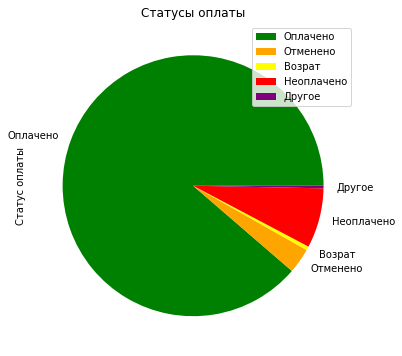

In [232]:
statuspayment = pd.DataFrame({'status': [paid, cancelled, Refunded, Unpaid, Other]},
                  index=['Оплачено', 'Отменено', 'Возрат', 'Неоплачено', 'Другое'])
plot = statuspayment.plot.pie(y='status', colors = ['green', 'orange', 'yellow', 'red', 'purple'], figsize=(6, 6), title ="Статусы оплаты")
plot.set_ylabel("Статус оплаты");


## pandas plot density

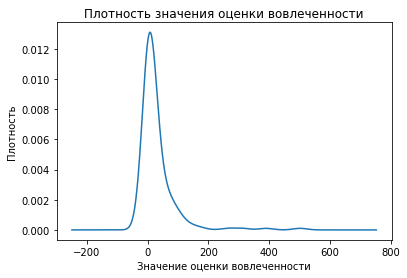

In [233]:
plt = df['engagement_score'].value_counts().plot(kind='density')
plt.set_title('Плотность значения оценки вовлеченности')
plt.set_xlabel('Значение оценки вовлеченности')
plt.set_ylabel('Плотность');

## pandas plot bar

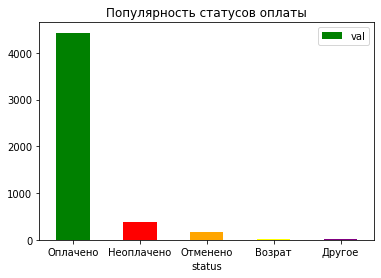

In [234]:
statuspayment = pd.DataFrame({'status':['Оплачено', 'Неоплачено', 'Отменено', 'Возрат',  'Другое'], 'val':[paid, Unpaid, cancelled, Refunded, Other]})
plot = statuspayment.plot.bar(x='status', y='val', rot=0, color = ['green', 'red', 'orange', 'yellow', 'purple'], title ="Популярность статусов оплаты")

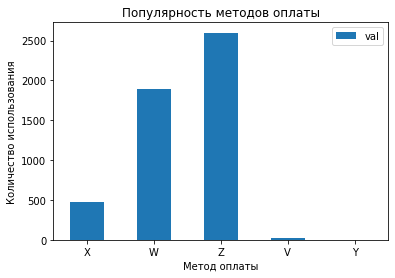

In [235]:
Methodpayment = pd.DataFrame({'method':['X', 'W', 'Z', 'V',  'Y'], 'val':[Xmethod, Wmethod, Zmethod, Vmethod, Ymethod]})
plot = Methodpayment.plot.bar(x='method', y='val', rot=0, title ="Популярность методов оплаты")
plot.set_xlabel("Метод оплаты");
plot.set_ylabel("Количество использования");

## Seaborn boxplot

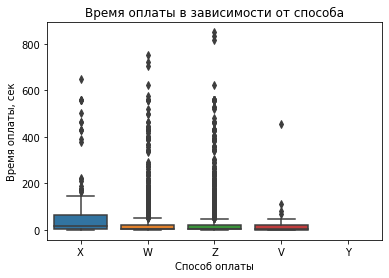

In [236]:
plt = sns.boxplot(x='payment_method', y='time_to_pay', data=df)
plt.set_title("Время оплаты в зависимости от способа");
plt.set_xlabel("Способ оплаты");
plt.set_ylabel("Время оплаты, сек");

## Seaborn countplot

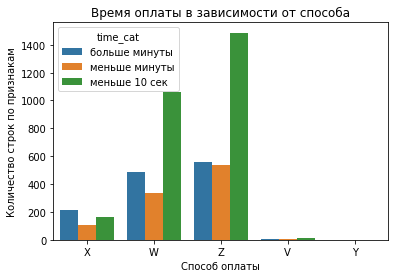

In [237]:
df['time_cat'] = df['time_to_pay'].apply(lambda time_payment: "меньше 10 сек" if time_payment < 10 else "меньше минуты" if time_payment < 60 else "больше минуты")
plt = sns.countplot(x='payment_method', hue = 'time_cat', data=df.loc[df['time_to_pay']!=0,:])
plt.set_title("Время оплаты в зависимости от способа");
plt.set_xlabel("Способ оплаты");
plt.set_ylabel("Количество строк по признакам");


## Seaborn distplot

c:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


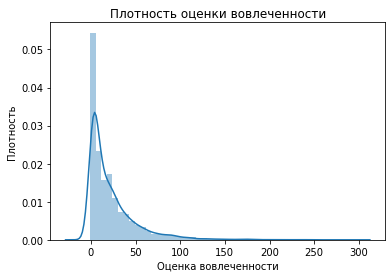

In [238]:
df.fillna(0, inplace = True)
plt = sns.distplot(df.engagement_score)
plt.set_title("Плотность оценки вовлеченности");
plt.set_xlabel("Оценка вовлеченности");
plt.set_ylabel("Плотность");

## Seaborn pairplot

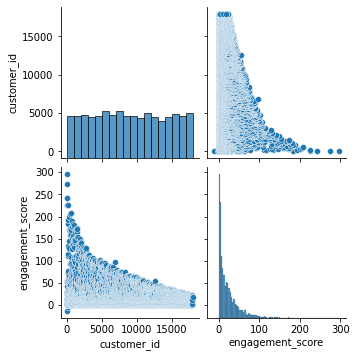

In [239]:
colums = ['customer_id', 'state', 'channel', 'engagement_score']
sns.pairplot(df[colums])

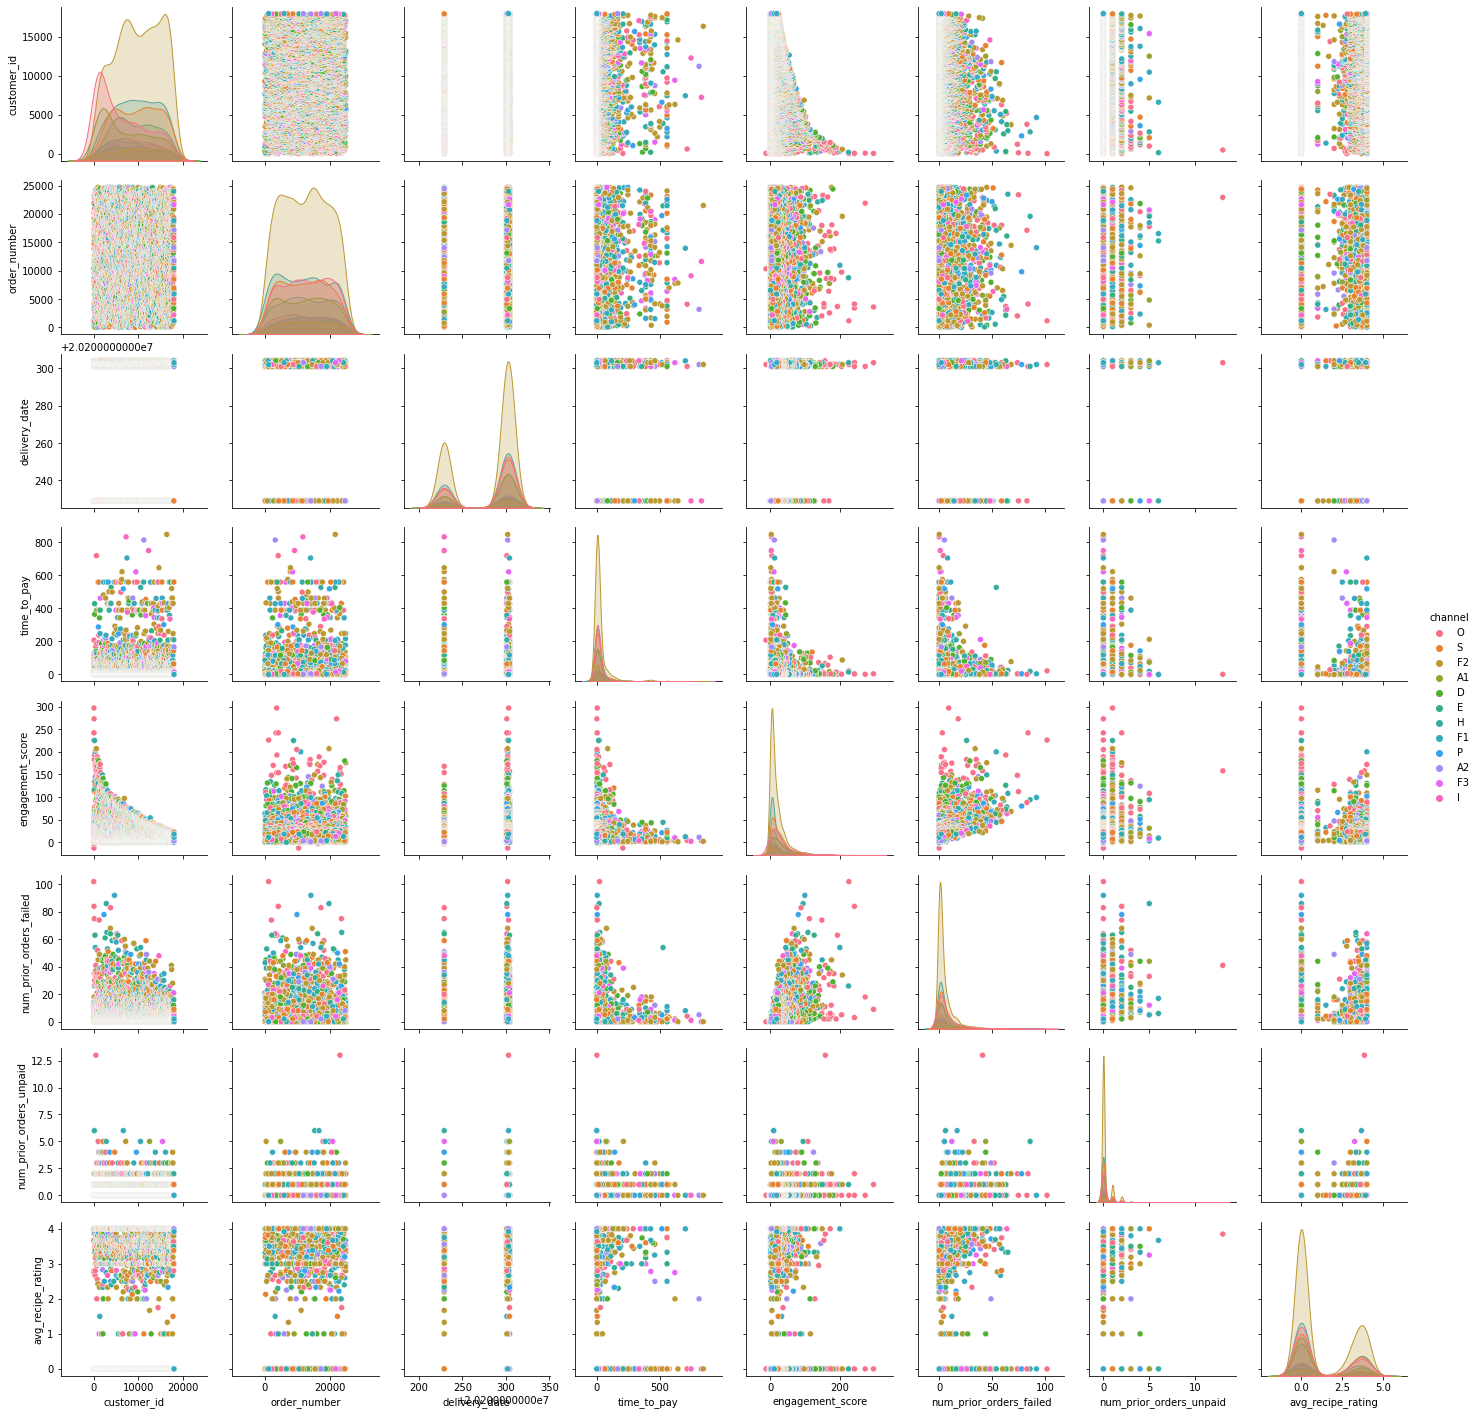

In [240]:
sns.pairplot(df, hue="channel")

## График плотности

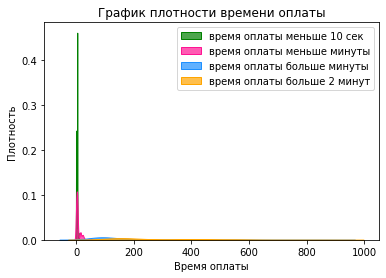

In [241]:
# Draw Plot
# plt.figure(figsize=(8,5), dpi= 80)
# plt.rcParams['figure.figsize'] = (8,5)
plt = sns.kdeplot(df.loc[df['time_to_pay'] < 10, "time_to_pay"], shade=True, color="g", label="время оплаты меньше 10 сек", alpha=.7)
sns.kdeplot(df.loc[df['time_to_pay'] < 60, "time_to_pay"], shade=True, color="deeppink", label="время оплаты меньше минуты", alpha=.7)
sns.kdeplot(df.loc[df['time_to_pay'] > 60, "time_to_pay"], shade=True, color="dodgerblue", label="время оплаты больше минуты", alpha=.7)
sns.kdeplot(df.loc[df['time_to_pay'] > 120, "time_to_pay"], shade=True, color="orange", label="время оплаты больше 2 минут", alpha=.7)

# Decoration
plt.set_title('График плотности времени оплаты')
plt.set_xlabel('Время оплаты')
plt.set_ylabel('Плотность')
plt.legend()
# plt.show()

# Модели

## Минимальная подготовка данных

In [242]:
data = pd.read_csv('test_data.csv')
dataOld = data.shape[0] * data.shape[1] #Изначально данных
target = data['final_payment_status']

# cols = ['delivery_week', 'payment_method','custom_meal_selection', 'state', 'channel']  #'delivery_week', 'payment_method','custom_meal_selection', 'state', 'channel'
# data = pd.get_dummies(data = data, columns = cols)

data = data.drop(columns='avg_recipe_rating')
data = data.drop(columns='time_to_pay')

In [243]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['final_payment_status'] = le.fit_transform(data['final_payment_status'])
data['delivery_week'] = le.fit_transform(data['delivery_week'])
data['payment_method'] = le.fit_transform(data['payment_method'])
data['custom_meal_selection'] = le.fit_transform(data['custom_meal_selection'])
data['state'] = le.fit_transform(data['state'])
data['channel'] = le.fit_transform(data['channel'])

In [244]:
target = data['final_payment_status']

In [245]:
print(f'Строк:{data.shape[0]}, Колонок: {data.shape[1]}')
print(f'Процент данных: {data.shape[0] * data.shape[1]}/{dataOld} = {(data.shape[0] * data.shape[1]/dataOld) * 100}%');

Строк:4998, Колонок: 12
Процент данных: 59976/69972 = 85.71428571428571%


In [246]:
data

,customer_id,order_number,delivery_date,delivery_week,final_payment_status,payment_method,custom_meal_selection,state,channel,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid
0,6,17266,20200229,0,0,2,1,2,9,3,1,0
1,7,10494,20200301,0,2,1,2,4,9,29,14,0
2,8,10384,20200303,0,2,4,2,2,11,17,9,0
3,9,3396,20200303,0,2,1,2,6,9,242,3,0
4,13,1146,20200302,0,2,4,2,2,9,226,102,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4993,17922,21627,20200303,0,2,4,0,6,6,13,4,0
4994,17924,11742,20200303,0,2,1,2,2,1,3,0,0
4995,17926,17142,20200301,0,2,4,2,4,1,3,2,0
4996,17932,1157,20200302,0,2,1,2,4,4,11,0,0


In [247]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,
                                                          random_state=15)

## DecisionTree

In [248]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=15)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=15)

In [249]:
target_names = ['Cancelled', 'Paid', 'Unpaid', 'Other', 'Refunded']
print(classification_report(y_test, clf_tree.predict(X_test), target_names=target_names ))

              precision    recall  f1-score   support

   Cancelled       1.00      1.00      1.00        30
        Paid       1.00      1.00      1.00         1
      Unpaid       1.00      1.00      1.00       888
       Other       1.00      1.00      1.00         7
    Refunded       1.00      1.00      1.00        74

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [250]:
# Извлекаем значимость параметров
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': clf_tree.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Выводим значения
fi.head()

,feature,importance
4,final_payment_status,1.0
0,customer_id,0.0
1,order_number,0.0
2,delivery_date,0.0
3,delivery_week,0.0


## Neariest Neighbors

In [251]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)

In [252]:
target_names = ['Cancelled', 'Paid', 'Unpaid', 'Other', 'Refunded']
print(classification_report(y_test, pred_knn, zero_division='warn', target_names=target_names ))

              precision    recall  f1-score   support

   Cancelled       0.00      0.00      0.00        30
        Paid       0.00      0.00      0.00         1
      Unpaid       0.89      1.00      0.94       888
       Other       0.00      0.00      0.00         7
    Refunded       0.33      0.01      0.03        74

    accuracy                           0.89      1000
   macro avg       0.24      0.20      0.19      1000
weighted avg       0.81      0.89      0.84      1000



c:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Выводятся 0.00 тк у данных меток несбалансированные данные

## Logistic Regression

In [253]:
logit = LogisticRegression(C=0.5, random_state=15, solver='liblinear')
logit.fit(X_train, y_train)
pred_log = logit.predict(X_test)

In [254]:
target_names = ['Cancelled', 'Paid', 'Unpaid', 'Other', 'Refunded']
print(classification_report(y_test, pred_log, zero_division='warn', target_names=target_names ))

              precision    recall  f1-score   support

   Cancelled       0.00      0.00      0.00        30
        Paid       0.00      0.00      0.00         1
      Unpaid       0.89      1.00      0.94       888
       Other       0.00      0.00      0.00         7
    Refunded       0.00      0.00      0.00        74

    accuracy                           0.89      1000
   macro avg       0.18      0.20      0.19      1000
weighted avg       0.79      0.89      0.84      1000



c:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Выводятся 0.00 тк у данных меток несбалансированные данные

## Random Forest

In [255]:
from sklearn.ensemble import RandomForestRegressor
# Модель леса из 10 деревьев
rndforest = RandomForestRegressor(n_estimators=20, oob_score=True, random_state=15)
rndforest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, oob_score=True, random_state=15)

In [256]:
# Действующая классификация
pred_rndforest = rndforest.predict(X_test)

In [257]:
target_names = ['Cancelled', 'Paid', 'Unpaid', 'Other', 'Refunded']
print(classification_report(y_test, pred_rndforest, zero_division='warn', target_names=target_names ))

              precision    recall  f1-score   support

   Cancelled       1.00      1.00      1.00        30
        Paid       1.00      1.00      1.00         1
      Unpaid       1.00      1.00      1.00       888
       Other       1.00      1.00      1.00         7
    Refunded       1.00      1.00      1.00        74

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



## Boosting

In [258]:
from sklearn.ensemble import GradientBoostingClassifier
gradient = GradientBoostingClassifier(random_state=4)
gradient.fit(X_train, y_train)
pred_gradient = gradient.predict(X_test)

In [259]:
target_names = ['Cancelled', 'Paid', 'Unpaid', 'Other', 'Refunded']
print(classification_report(y_test, pred_gradient, zero_division='warn', target_names=target_names ))

              precision    recall  f1-score   support

   Cancelled       1.00      1.00      1.00        30
        Paid       1.00      1.00      1.00         1
      Unpaid       1.00      1.00      1.00       888
       Other       1.00      1.00      1.00         7
    Refunded       1.00      1.00      1.00        74

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



# МУСОР

In [260]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# model_OHE = ColumnTransformer([('final_payment_status', OneHotEncoder(),[4])], remainder = 'passthrough')
# model_OHE2 = ColumnTransformer([('PayMethod', OneHotEncoder(),['payment_method'])], remainder = 'passthrough')
# model_OHE3 = ColumnTransformer([('State', OneHotEncoder(),['state'])], remainder = 'passthrough')
# model_OHE4 = ColumnTransformer([('Channel', OneHotEncoder(),['channel'])], remainder = 'passthrough')
# model_OHE5 = ColumnTransformer([('DelWeek', OneHotEncoder(),['delivery_week'])], remainder = 'passthrough')
# model_OHE6 = ColumnTransformer([('CustomMeal', OneHotEncoder(),['custom_meal_selection'])], remainder = 'passthrough')
# data['final_payment_status'] = model_OHE.fit_transform(data)
# data['payment_method'] = model_OHE2.fit_transform(data)
# data['state'] = model_OHE3.fit_transform(data)
# data['channel'] = model_OHE4.fit_transform(data)
# data['delivery_week'] = model_OHE5.fit_transform(data)
# data['custom_meal_selection'] = model_OHE6.fit_transform(data)

In [261]:
# data['final_payment_status'] = data['final_payment_status'].astype(float)
# data['payment_method'] = data['payment_method'].astype(float)
# data['state'] = data['state'].astype(float)
# data['channel'] = data['channel'].astype(float)
# data['delivery_week'] = data['delivery_week'].astype(float)
# data['custom_meal_selection'] = data['custom_meal_selection'].astype(float)

## График подсчета (Counts Plot)

In [263]:
# df_counts = df.groupby(['customer_id', 'state']).size().reset_index(name='counts')
# fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(8,6), dpi= 80)
# sns.scatterplot(df_counts.state, df_counts.customer_id, size=df_counts.counts*2, ax=ax)

# plt.title('Плотность клиентов в штатах')
# plt.xlabel("Штаты")
# plt.ylabel("ID Клиентов")
# plt.show()

In [264]:
# df_counts = df.groupby(['time_to_pay', 'payment_method']).size().reset_index(name='counts')

# fig, ax = plt.subplots(figsize=(6,5), dpi= 80)    
# sns.scatterplot(df_counts.payment_method, df_counts.time_to_pay, size=df_counts.counts*2, ax=ax)

# plt.title('Затраченное время на оплату разными способами')
# plt.xlabel("Способ оплаты")
# plt.ylabel("Затраченное время, сек")
# plt.show()

## Расходящиеся столбцы

In [265]:
# # Prepare Data
# x = df.loc[:, ['engagement_score']]
# # x = df['time_to_pay']
# df['engagement_score_z'] = (x - x.mean())/x.std()
# df['colors'] = ['red' if x < 0 else 'green' for x in df['engagement_score_z']]
# df.sort_values('engagement_score_z', inplace=True)
# df.reset_index(inplace=True)

# # Draw plot
# plt.figure(figsize=(20,16), dpi= 60)
# plt.hlines(y=df.index, xmin=0, xmax=df.engagement_score_z, color=df.colors, alpha=0.4, linewidth=5)

# # Decorations
# plt.gca().set(ylabel='Клиент', xlabel='Оценка вовлеченности')
# plt.yticks(df.index, df.customer_id)
# plt.title('Изменения времени оплаты в зависимости от способа')
# plt.grid(linestyle='--', alpha=0.5)
# plt.show()

In [266]:
# # Prepare Data
# data = pd.read_csv("https://github.com/selva86/datasets/raw/master/mtcars.csv")
# x = data.loc[:, ['mpg']]
# data['mpg_z'] = (x - x.mean())/x.std()
# data['colors'] = ['red' if x < 0 else 'green' for x in data['mpg_z']]
# data.sort_values('mpg_z', inplace=True)
# data.reset_index(inplace=True)

# # Draw plot
# plt.figure(figsize=(14,10), dpi= 80)
# plt.hlines(y=data.index, xmin=0, xmax=data.mpg_z, color=data.colors, alpha=0.4, linewidth=5)

# # Decorations
# plt.gca().set(ylabel='$Model$', xlabel='$Mileage$')
# plt.yticks(data.index, data.cars, fontsize=12)
# plt.title('Diverging Bars of Car Mileage', fontdict={'size':20})
# plt.grid(linestyle='--', alpha=0.5)
# plt.show()